# Scoring well on chessable.com
In this project we will focus on how to get the most from a chessable course. The aim will be to crawl into the skin of a chess professional and find out which course they should make to get the most out of the platform.

There are 23 relevant columns  
1: **course_link**  
2: **course_title**  
3: **course_type** -- This field specifies about which field the course is about. Opening, Tactics, Strategy, Endgame or a combination. There is also a bundle option.  
4: **author** -- The author of the course, which can be a real name or an alias. This field also includes their chess titles: NM, CM, FM, IM, GM and women titles with a W in front of it.  
5: **price** -- Course price in €.  
6: **price_with_video** -- Price in € for additional video material. Contains missing values.  
7: **course_rating** -- Ratings based on a five star system.  
8: **course_rating_count** -- The amount of ratings per course.  
9: **rubies** -- The amount of rubies donated to a course. One Ruby = \\$0.05  
10: **target_color** -- The color at which the course is aimed: black, white or both.  
11: **beginning** -- The following five columns represent the target audience rating: ELO 800 - 1000  
12: **casual** -- ELO 1000 - 1400  
13: **intermediate** -- ELO 1400 - 1800  
14: **advanced** -- ELO 1800 - 2100  
15: **expert** -- ELO 2000 - 2400  
16: **language**  
17: **instruction_word_count** -- The amount of feedback in words per course.  
18: **free_video** -- The duration of free video available.  
19: **trainable_variations** -- The amount of variations with feedback-training.  
20: **avg_line_depth** -- The average amount of moves per variation.  
21: **released_on** -- The releasedate of the course.  
22: **support_level**  
23: **section** -- This field describes the nature of the contributor: Titled player, Community or Publisher.  

## The target

The target is not easily defined yet. One can focus on average rating, rating counts or even rubies (donations). For free courses, the amount of rubies is more important in a sense that the author would make more. At least that's what one would think. The donations in rubies do not go to the authors themselves. They go to the platform chessable. 

Therefore it is safe to say that the best column to select as our target would be **course_rating_count**. One can only vote on a paid course when one has actually paid for the course, so that is a sure sign of purchase. 

## The method

In this investigation we will first do some exploratory data analysis after some minor cleaning. After that we will try to train a simple linear model to select the best features for our analysis. Those will be the *features* to answer our initial question. What kind of courses are successful on chessable?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression

chessable = pd.read_csv("chessable_clean_30072020.csv", index_col = False)
chessable.head()

,Unnamed: 0,course_link,course_title,course_type,author,price,price_with_video,course_rating,course_rating_count,rubies,...,advanced,expert,language,instruction_word_count,free_video,trainable_variations,avg_line_depth,released_on,support_level,section
0,0,short-sweet-legendary-tactics/course/47106/,Short & Sweet: Legendary Tactics,Tactics/Strategy course,GM GM Pascal Charbonneau,0.0,NaN,4.7,30,14,...,1,1,English,"1,212",1 hour and 59 minutes,24,9.29,"Jul 24, 2020",High,Titled player
1,1,chessable-masters-tournament/course/43805/,Chessable Masters Tournament,Tactics/Strategy course,Chessable,0.0,NaN,4.5,88,59,...,1,0,English,126,4 hours and 31 minutes,65,16.36,"Jun 21, 2020",High,Titled player
2,2,short-sweet-the-black-lion/course/35086/,Short & Sweet: The Black Lion,Opening course,GM GingerGM,0.0,NaN,4.7,198,119,...,0,0,English,"6,210",1 hour and 5 minutes,24,13.63,"Mar 11, 2020",High,Titled player
3,3,short-and-sweet-jan-gustafssons-1-e4-e5/course...,Short and Sweet: Jan Gustafsson's 1. e4 e5,Opening course,Chessable,0.0,NaN,4.6,242,123,...,0,0,English,"9,820",NaN,37,17.00,"Dec 13, 2019",High,Community
4,4,short-sweet-queens-gambit-declined/course/34082/,Short & Sweet: Queen's Gambit Declined,Opening course,GM Alex Colovic,0.0,NaN,4.4,73,44,...,0,0,English,"3,932",38 minutes,20,15.83,"Jun 19, 2020",High,Titled player


In [2]:
#making some last cleaning efforts
chessable['released_on'] = pd.to_datetime(chessable['released_on'])
chessable = chessable.drop("Unnamed: 0", axis = 1)
chessable.course_type = chessable.course_type.str[:-7] #Deleting the 'course' after every word.
chessable.rubies = chessable.rubies.str.replace(',','').astype('int')
chessable.instruction_word_count = chessable.instruction_word_count.str.replace(',','').astype('int')

In [3]:
#Cleaning the times
import re

def p_time(val):
    try:
        t = 0
        h = re.search(r"(\d+) hour(s)?", val)
        if h:
            t += int(h.group(1)) * 60
        m = re.search(r"(\d+) minute(s)?", val)
        if m:
            t += int(m.group(1))
        return t
    except:
        pass
    return 0

chessable['free_video_minutes'] = chessable['free_video'].apply(p_time)
chessable = chessable.drop('free_video',axis=1)
chessable['free_video_minutes'].head()

0    119
1    271
2     65
3      0
4     38
Name: free_video_minutes, dtype: int64

In [4]:
chessable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   course_link             376 non-null    object        
 1   course_title            376 non-null    object        
 2   course_type             376 non-null    object        
 3   author                  376 non-null    object        
 4   price                   376 non-null    float64       
 5   price_with_video        264 non-null    float64       
 6   course_rating           376 non-null    float64       
 7   course_rating_count     376 non-null    int64         
 8   rubies                  376 non-null    int32         
 9   target_color            376 non-null    object        
 10  beginning               376 non-null    int64         
 11  casual                  376 non-null    int64         
 12  intermediate            376 non-null    int64     

In [5]:
chessable.corr().style.background_gradient(cmap='coolwarm')

,price,price_with_video,course_rating,course_rating_count,rubies,beginning,casual,intermediate,advanced,expert,instruction_word_count,trainable_variations,avg_line_depth,free_video_minutes
price,1.000000,0.645826,-0.024621,-0.174291,0.191886,-0.318878,0.009787,0.069276,0.400493,0.417311,0.663414,0.386647,-0.035307,0.249105
price_with_video,0.645826,1.000000,0.058513,0.154836,0.292484,-0.199988,-0.006316,0.019805,0.152345,0.268344,0.264580,0.070272,0.058044,0.735925
course_rating,-0.024621,0.058513,1.000000,0.102799,0.109979,0.034247,0.132108,-0.010758,0.020354,-0.077024,-0.093359,0.032561,-0.029969,0.075469
course_rating_count,-0.174291,0.154836,0.102799,1.000000,0.599349,0.111114,-0.016907,-0.120438,-0.211728,-0.129793,-0.074153,-0.049444,-0.123248,0.130719
rubies,0.191886,0.292484,0.109979,0.599349,1.000000,-0.051866,-0.030998,0.024173,0.022247,0.043293,0.141802,0.161139,-0.069960,0.222319
beginning,-0.318878,-0.199988,0.034247,0.111114,-0.051866,1.000000,0.407108,-0.201169,-0.589350,-0.392193,-0.285474,0.064259,-0.087189,-0.054396
casual,0.009787,-0.006316,0.132108,-0.016907,-0.030998,0.407108,1.000000,0.061318,-0.036761,-0.111791,-0.041500,0.091440,-0.017539,0.131702
intermediate,0.069276,0.019805,-0.010758,-0.120438,0.024173,-0.201169,0.061318,1.000000,0.322735,0.136824,0.079933,0.045592,0.260466,0.091842
advanced,0.400493,0.152345,0.020354,-0.211728,0.022247,-0.589350,-0.036761,0.322735,1.000000,0.444822,0.295452,-0.008787,0.163187,0.099556
expert,0.417311,0.268344,-0.077024,-0.129793,0.043293,-0.392193,-0.111791,0.136824,0.444822,1.000000,0.375702,0.053415,-0.028796,0.181515


## Correlations
From the above heatmap there are several things that interest us. 
* course_rating_count hardly correlates with any column except for rubies, which was to be expected. Of course the donations giveaway the fact if someone has bought the course. 
* The price correlates mostly with the amount of trainable variations and the level. Courses for advanced and expert level are more expensive.

One conclusion to draw here is that we should not use a linear model to predict the amount of ratings. So, now we can go on with extracting new features from the string columns. 

## Feature engineering 
Two obvious features to extract are:
* The titles from the author's names
* The course types, by using one hot encoding.

In [6]:
chessable['titled_author'] = 'no title'  #Let's hope no author lied about their titles!
chessable.loc[chessable['author'].str.contains(r'^GM'), 'titled_author'] = 'GM'
chessable.loc[chessable['author'].str.contains(r'WGM'), 'titled_author'] = 'WGM'
chessable.loc[chessable['author'].str.contains(r'^IM'), 'titled_author'] = 'IM'
chessable.loc[chessable['author'].str.contains(r'WIM'), 'titled_author'] = 'WIM'
chessable.loc[chessable['author'].str.contains(r'^FM'), 'titled_author'] = 'FM'
chessable.loc[chessable['author'].str.contains(r'WFM'), 'titled_author'] = 'WFM'
chessable.loc[chessable['author'].str.contains(r'^CM'), 'titled_author'] = 'CM'
chessable.loc[chessable['author'].str.contains(r'WCM'), 'titled_author'] = 'WCM'
chessable['titled_author'].value_counts()

no title    184
GM           73
IM           58
FM           48
CM            7
WFM           5
WIM           1
Name: titled_author, dtype: int64

In [7]:
dummy_course_types = pd.get_dummies(chessable['course_type'], prefix= 'type')
chessable = pd.concat([chessable,dummy_course_types],axis = 1).drop('course_type',axis=1)

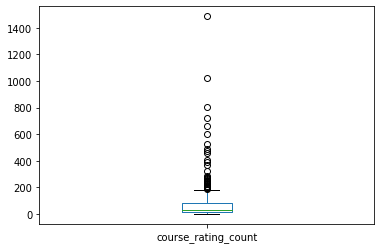

In [8]:
chessable.course_rating_count.plot.box() #checking the distribution. There are just a few outliers. 

In [9]:
chessable.corr().style.background_gradient(cmap='coolwarm')

,price,price_with_video,course_rating,course_rating_count,rubies,beginning,casual,intermediate,advanced,expert,instruction_word_count,trainable_variations,avg_line_depth,free_video_minutes,type_Endgame,type_Endgame/Tactics,type_Opening,type_Opening/Tactics,type_Strategy,type_Strategy/Endgame,type_Strategy/Opening,type_Strategy/Tactics,type_Tactics,type_Tactics/Endgame,type_Tactics/Opening,type_Tactics/Strategy
price,1.000000,0.645826,-0.024621,-0.174291,0.191886,-0.318878,0.009787,0.069276,0.400493,0.417311,0.663414,0.386647,-0.035307,0.249105,-0.041075,0.068666,-0.213341,0.147475,-0.021659,0.090363,0.034491,0.161759,0.036102,0.075024,0.034491,0.109330
price_with_video,0.645826,1.000000,0.058513,0.154836,0.292484,-0.199988,-0.006316,0.019805,0.152345,0.268344,0.264580,0.070272,0.058044,0.735925,-0.085364,0.015690,0.160831,0.069027,0.063665,0.127953,-0.019241,0.034160,-0.225630,-0.052276,0.009193,0.025001
course_rating,-0.024621,0.058513,1.000000,0.102799,0.109979,0.034247,0.132108,-0.010758,0.020354,-0.077024,-0.093359,0.032561,-0.029969,0.075469,0.058471,0.047895,-0.026030,-0.058052,-0.003224,0.033821,-0.042214,0.027110,0.010915,0.030986,0.014813,-0.028290
course_rating_count,-0.174291,0.154836,0.102799,1.000000,0.599349,0.111114,-0.016907,-0.120438,-0.211728,-0.129793,-0.074153,-0.049444,-0.123248,0.130719,0.236893,-0.033798,0.022961,-0.039249,-0.039151,-0.024434,-0.027080,-0.043385,-0.028548,-0.048042,-0.025946,-0.044628
rubies,0.191886,0.292484,0.109979,0.599349,1.000000,-0.051866,-0.030998,0.024173,0.022247,0.043293,0.141802,0.161139,-0.069960,0.222319,0.184518,-0.024490,-0.034962,-0.008762,-0.040731,-0.016192,-0.025187,-0.026712,0.023717,-0.042433,-0.026105,-0.012288
beginning,-0.318878,-0.199988,0.034247,0.111114,-0.051866,1.000000,0.407108,-0.201169,-0.589350,-0.392193,-0.285474,0.064259,-0.087189,-0.054396,-0.038185,0.021929,-0.077842,0.015054,-0.066559,-0.038426,-0.038426,-0.029018,0.229406,-0.071233,0.069397,-0.108436
casual,0.009787,-0.006316,0.132108,-0.016907,-0.030998,0.407108,1.000000,0.061318,-0.036761,-0.111791,-0.041500,0.091440,-0.017539,0.131702,-0.069117,-0.041624,-0.146843,0.096110,0.024703,-0.088813,0.030026,-0.047286,0.185485,-0.041511,0.030026,0.034805
intermediate,0.069276,0.019805,-0.010758,-0.120438,0.024173,-0.201169,0.061318,1.000000,0.322735,0.136824,0.079933,0.045592,0.260466,0.091842,0.058929,0.021140,0.091563,0.047785,0.007993,0.014929,0.014929,0.004201,-0.103648,-0.026456,-0.178628,-0.059921
advanced,0.400493,0.152345,0.020354,-0.211728,0.022247,-0.589350,-0.036761,0.322735,1.000000,0.444822,0.295452,-0.008787,0.163187,0.099556,0.087134,-0.025546,-0.071287,0.047312,0.087134,0.036661,0.036661,0.050337,-0.109745,0.065629,-0.072739,0.099059
expert,0.417311,0.268344,-0.077024,-0.129793,0.043293,-0.392193,-0.111791,0.136824,0.444822,1.000000,0.375702,0.053415,-0.028796,0.181515,-0.037111,0.035445,-0.094210,0.006644,-0.006908,0.082416,-0.032356,0.188981,-0.087885,0.194353,-0.032356,0.105019


Again we do not see a lot of correlation with our new columns. Two other things to note:
* Opening courses have the deepest avg_line_depth
* Tactics are slightly more popular with beginning and casual levels
* Tactics courses have a shallow avg_line_depth

               course_rating_count
titled_author                     
WFM                      14.400000
CM                       26.428571
WIM                      36.000000
FM                       45.270833
GM                       70.465753
no title                 73.472826
IM                      132.534483


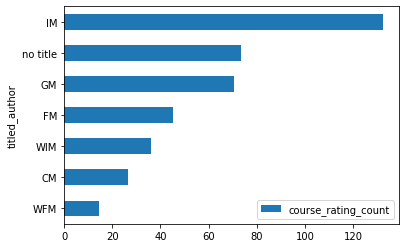

In [10]:
#Now we can see if the title matters
title_pivot = pd.pivot_table(chessable, values= 'course_rating_count', index= 'titled_author').sort_values('course_rating_count', axis=0)
print(title_pivot)
title_pivot.plot.barh()

The results here are quite surprising, one would expect that the GM courses would perform better. On the other hand, Grandmasters often spend more time playing than creating teaching material. International masters can be full-time trainers and hence they will be more well-known as a teacher. 

For the rest it is interesting to see that no title is so high. Let's examine the section columns more closely

               course_rating_count
section                           
Community                60.671875
Publisher                66.488889
Titled player            95.354430


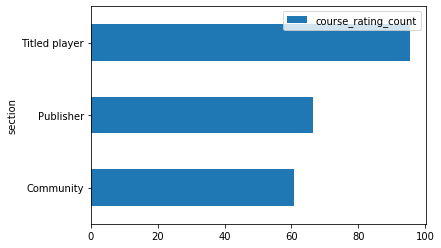

In [11]:
title_pivot2 = pd.pivot_table(chessable, values= 'course_rating_count', index= 'section').sort_values('course_rating_count', axis=0)
print(title_pivot2)
title_pivot2.plot.barh()

## Titled players score best
This is quite interesting, because publishers often create courses from books by, well, by titled players. However! If the players contribute it themselves the chances are larger that it will be a success. 

## Price category
Let's now look at the price categories and how that influences the course_rating_count.

                course_rating_count
price_cat                          
Very Cheap                23.229167
Cheap                     26.756410
Normal                    57.268293
Expensive                 63.085106
Very Expensive           111.222222
Free                     151.357143


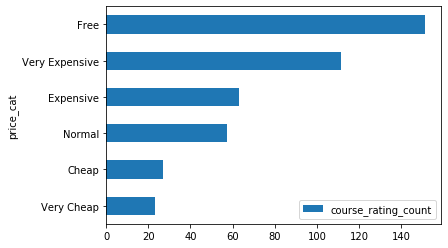

In [12]:
#First we create some price categories
chessable.loc[chessable['price'] == 0, 'price_cat'] = 'Free'
chessable.loc[(chessable['price'] > 0) & (chessable['price'] <= 10), 'price_cat'] = 'Very Cheap'
chessable.loc[(chessable['price'] > 10) & (chessable['price'] <= 20), 'price_cat'] = 'Cheap'
chessable.loc[(chessable['price'] > 20) & (chessable['price'] <= 30), 'price_cat'] = 'Normal'
chessable.loc[(chessable['price'] > 30) & (chessable['price'] <= 40), 'price_cat'] = 'Expensive'
chessable.loc[chessable['price'] > 40, 'price_cat'] = 'Very Expensive'

price_pivot = pd.pivot_table(chessable, values= 'course_rating_count', index= 'price_cat').sort_values('course_rating_count', axis=0)
print(price_pivot)
price_pivot.plot.barh()

### Price conclusion
The results are quite interesting. We see that the more expensive a course becomes the more people are going to buy it, except in the case of a free course. Therefore I would recommend to price a course above the €30 at least. But I would almost recommend to set the price to over €40 if you have made a decent course.

In connection with our correlation matrix we can also see that price correlates with expert and advanced level. Which means people are more willing to pay for more complicated material. And that these categories should be the area to focus on if making money is the goal of the course.

## Recursive feature elimination
Right now it is time to use a decision tree model to select the features which are the most useful for predicting the course_rating_count. There will be a lot happening under the hood of the RFECV function. Basically it will train a few models and select the columns which give the most information gain. 

Information gain is quite easy to grasp in a decision tree let's consider the following case:
![img](https://miro.medium.com/max/820/0*LHzDR-s89Ggfqn7p.png)

Here the decision tree tries to find out if someone is fit. We can intuitively grasp that eating pizza is not giving the most information gain. Someone can be over 70 and not do morning exercises while not eating pizza. Then the person would still not be fit. So the feature that is put first to optimize the model gives the most information gain. 

Those will be displayed in the ranking in the following function.

In [13]:
#First we need to convert our categorical columns to dummy columns
def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    df = create_dummies(df,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

final = chessable
final = create_dummies(final, "titled_author")
final = create_dummies(final, "price_cat")
final = create_dummies(final, "section")

In [14]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

#Splitting in a train and target
final = final.dropna(axis=1).select_dtypes(include=np.number)
target = chessable['course_rating_count']
final = final.drop('course_rating_count', axis=1)

#Here we normalize the values, which is practical for linear_regression
x = final.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
final = pd.DataFrame(x_scaled, columns=final.columns)

rf = RandomForestRegressor(random_state = 1, n_jobs = -1) #making results reproducible
selector = RFECV(rf, cv=5, n_jobs = -1)
selector.fit(final, target)

print(pd.concat([pd.Series(final.columns), pd.Series(selector.ranking_)],axis=1)) #This creates an inclusion score. 1 is inclusion.

                           0   1
0                      price   1
1              course_rating   1
2                     rubies   1
3                  beginning   1
4                     casual   1
5               intermediate   1
6                   advanced   1
7                     expert   1
8     instruction_word_count   1
9       trainable_variations   1
10            avg_line_depth   1
11        free_video_minutes   1
12              type_Endgame   1
13      type_Endgame/Tactics  11
14              type_Opening   1
15      type_Opening/Tactics   1
16             type_Strategy   3
17     type_Strategy/Endgame  10
18     type_Strategy/Opening  12
19     type_Strategy/Tactics   4
20              type_Tactics   1
21      type_Tactics/Endgame   6
22      type_Tactics/Opening  13
23     type_Tactics/Strategy   1
24          titled_author_CM   5
25          titled_author_FM   1
26          titled_author_GM   1
27          titled_author_IM   1
28         titled_author_WFM   9
29        

With random forests we do not seem to get any idea which features are important. It ranks most columns important.
Let's see what linear regression does.

In [15]:
lr = LinearRegression(n_jobs = -1)
selector = RFECV(lr, cv=5, n_jobs = -1)
selector.fit(final, target)

print(pd.concat([pd.Series(final.columns), pd.Series(selector.ranking_)],axis=1))

                           0   1
0                      price  26
1              course_rating  34
2                     rubies   1
3                  beginning  35
4                     casual  32
5               intermediate  28
6                   advanced  33
7                     expert  36
8     instruction_word_count  31
9       trainable_variations  30
10            avg_line_depth  27
11        free_video_minutes  29
12              type_Endgame   1
13      type_Endgame/Tactics   2
14              type_Opening  24
15      type_Opening/Tactics  10
16             type_Strategy   6
17     type_Strategy/Endgame   5
18     type_Strategy/Opening  21
19     type_Strategy/Tactics   9
20              type_Tactics  12
21      type_Tactics/Endgame  23
22      type_Tactics/Opening  13
23     type_Tactics/Strategy   7
24          titled_author_CM   8
25          titled_author_FM  17
26          titled_author_GM  25
27          titled_author_IM   1
28         titled_author_WFM  16
29        

## Conclusions feature selection
I would not trust this data too much because linear regression is very sensitive to outliers. Well, unfortunately we do not have a lot of information. We need to see how the models are scoring to draw a conclusion.

In [16]:
from sklearn.model_selection import cross_val_score

#Here we take the mean absolute error, which means how much the model was off on average. 
#Here we should have dropped rubies and ratings if this model would be trained for other goals than feature selection.
print('LinearRegression:', cross_val_score(lr,final,target, scoring = 'neg_mean_absolute_error'))
print('Random Forests:', cross_val_score(rf,final,target, scoring = 'neg_mean_absolute_error'))
print('LinearRegression with selected cols:', cross_val_score(lr,final[['price','advanced','type_Endgame','price_cat_Free','price_cat_Very Expensive','titled_author_IM']],target, scoring = 'neg_mean_absolute_error'))

LinearRegression: [-69.959828   -65.15394608 -98.66666667 -52.72381424 -86.59341036]
Random Forests: [-80.13868421 -63.16546667 -28.50666667 -29.81773333 -33.286     ]
LinearRegression with selected cols: [-88.48995765 -76.54996193 -52.22856434 -45.13968146 -52.60600451]


# Conclusion
All in all the machine learning efforts have been in vain. The data is too sparse to draw very meaningful conclusions. But if we have to say something it is that Random Forests performs significantly better than linear regression. Even after selecting the best columns from the feature selection process, Linear Regression performs poorly. 

That means that the correlation is not obvious for a linear model. For example a variable like average variation depth does not tell us that much. Neither does price. On the other hand, all together they are much more able to predict the rating count. 

This means that every feature is around equally important for estimating the end result. There is no real golden metric to adhere for prediction. But if that is the case we can say that there is hardly anything to pay attention to. 

The only takeaways are the following:
* The more expensive a course is the more it is sold.
* The IM's score better than the other titles.
* We **definitely** need more data to draw better conclusions.